In [1]:
import glob
import numpy as np
print('numpy version: ', np.__version__)
import astropy
print('astropy version: ', astropy.__version__)
from astropy.io import fits
from astropy import wcs
import asdf
print('asdf version: ', asdf.__version__)
import gwcs
print('gwcs version: ', gwcs.__version__)
import jwst
print('jwst version: ', jwst.__version__, jwst.__file__)

numpy version:  1.12.1
astropy version:  3.1.dev21681
asdf version:  2.0.0.dev1290
gwcs version:  0.9.dev332
jwst version:  0.9.3a.dev96 /internal/1/astropy/jwst/jwst/__init__.py


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
from jwst import datamodels
from jwst.assign_wcs.nirspec import nrs_wcs_set_input

In [4]:
!/internal/1/astropy/jwst/scripts/strun assign_wcs.cfg prism.fits

2018-04-16 09:57:19,340 - stpipe.assign_wcs - INFO - AssignWcsStep instance created.
2018-04-16 09:57:19,367 - stpipe.assign_wcs - INFO - Step assign_wcs running with args ('prism.fits',).
2018-04-16 09:57:19,993 - stpipe.assign_wcs - INFO - gwa_ytilt is 0.03312480077147484 deg
2018-04-16 09:57:19,993 - stpipe.assign_wcs - INFO - gwa_xtilt is 0.3411945700645447 deg
2018-04-16 09:57:19,994 - stpipe.assign_wcs - INFO - theta_y correction: -0.005294283663966503 deg
2018-04-16 09:57:19,995 - stpipe.assign_wcs - INFO - theta_x correction: 0.0 deg
2018-04-16 09:57:36,593 - stpipe.assign_wcs - INFO - Created a NIRSPEC nrs_ifu pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_nirspec_wavelengthrange_0004.asdf', 'camera': '/grp/crds/cache/references/jwst/jwst_nirspec_camera_0004.asdf', 'collimator': '/grp/crds/cache/references/jwst/jwst_nirspec_collimator_0004.asdf', 'disperser': '/grp/c

In [5]:
im = datamodels.ImageModel('prism_assign_wcs.fits')

### Tilt Correction:

In [6]:
print("ESA Trace file:", fits.getval("./esa/Trace_IFU_Slice_00_SIMA-QUAL-04-B-6007022859_37668_JLAB88.fits", keyword="THETAY"))
print("Pipeline correction: {0} arcsec".format(-0.005294283663966503 * 3600))

ESA Trace file: -19.05942119027941
Pipeline correction: -19.05942119027941 arcsec


### Test 1

For each Trace file:
- Compute the pixel indices (x, y) for values in the SLIT extension that are between -0.5 and 0.5 (within the slit).
- Get the wavelength values for these pixels from the LAMBDA1 extension, the y-slit positions from the SLIT1 extension and teh MSa positions from the MSAY1 and MSAX1 extensions.
- Transfer these (x, y) to full frame coordinates using the FITS WCS in the Trace file.
- Evaluate the pipeline WCS passing these x, y as input to obtain ra, dec, lam from the pipeline code.
- Compute the difference between the ESA and pipeline wavelengths for these x, y pixels.
- Compute the difference in the y_slit position and MSAY positions

In [7]:
# Create a list of all TRACE* files from ESA. The files are expected to be in the a subdirectory called "esa".
esa = glob.glob("esa/Trace*.fits")

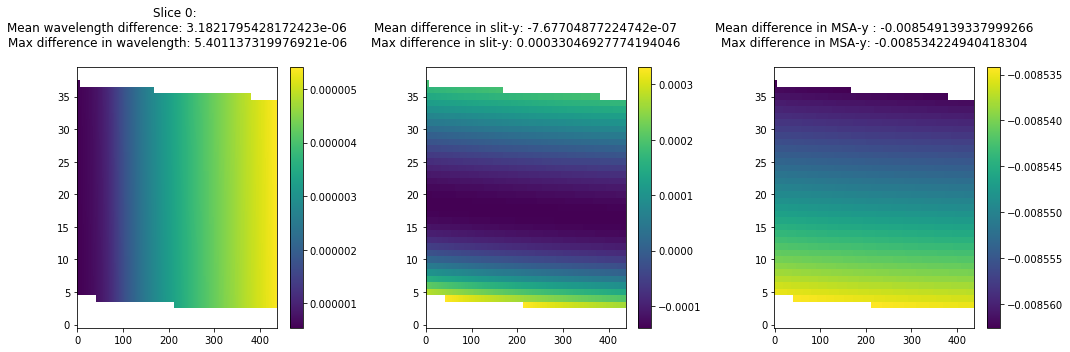

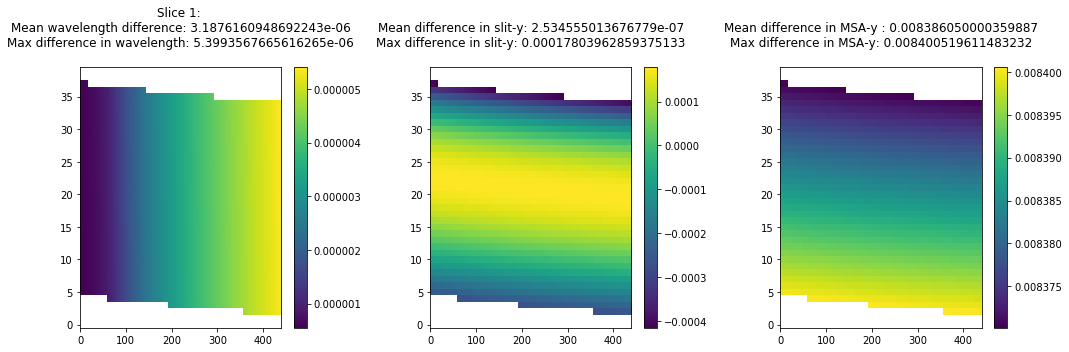

In [13]:
for trace in esa[:2]:
    # Open the Trace file and ead the extensions
    tr = fits.open(trace)
    #tr.info()
    lam1 = tr[4].data
    slit1 = tr[5].data
    msay1 = tr[7].data
    pyw = wcs.WCS(tr[4].header)
    slice_id = tr[0].header['SLICEID']
    tr.close()

    # Create x, y indices using the Trace WCS
    y, x =np.mgrid[:lam1.shape[0], : lam1.shape[1]]
    x1, y1 = pyw.all_pix2world(x, y, 0)

    # Get the WCS for this particular slice
    wcs_slice = nrs_wcs_set_input(im, slice_id)
    # Compute ra, dec and lambda
    ra, dec, lam = wcs_slice(x1-1, y1-1) # use 0-based coordinates
    
    #!!! Better lam at msa and slit than at world
    detector2slit = wcs_slice.get_transform("detector", "slit_frame")
    sx, sy, lam = detector2slit(x1-1, y1-1)
    detector2msa = wcs_slice.get_transform("detector", "msa_frame")
    msax, msay, _ = detector2msa(x1-1, y1-1)
    lam *= 10**-6
    diff = lam1 - lam
    
    # Compute the difference in wavelength
    #diff = lam1 - lam
    #title = "Slice {}: \n".format(slice_id)
    #title += "Mean wavelength difference: {}\n".format(np.mean(diff[notnan]))
    #title += "Max difference in wavelength: {}\n".format(np.max(diff[notnan]))

    # Compute the difference in slit-y positions
    detector2slit = wcs_slice.get_transform("detector", "slit_frame")
    sx, sy, l = detector2slit(x1-1, y1-1)
    diffslit = slit1 - sy
    
    
    
    nanind = np.isnan(lam)
    #lam1[nanind] = np.nan
    oneind = lam1 == -1
    lam[oneind] = np.nan
    notnan = ~np.isnan(lam)
    
    title = "Slice {}: \n".format(slice_id)
    title += "Mean wavelength difference: {}\n".format(np.mean(diff[notnan]))
    title += "Max difference in wavelength: {}\n".format(np.max(diff[notnan]))
    
    # Compute the difference in MSa-y positions
    detector2msa = wcs_slice.get_transform("detector", "msa_frame")
    msax, msay, _ = detector2msa(x1-1, y1-1)
    
    diffmsa = msay1- msay
    
    # Plot differences and some statistics
    titles = "Mean difference in slit-y: {}\n".format(np.mean(diffslit[notnan]))
    titles += "Max difference in slit-y: {}\n".format(np.max(diffslit[notnan]))
    fig = plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(1, 3, 1)
    i1 = ax1.imshow(diff, aspect='auto')
    plt.title(title)
    plt.colorbar(i1, ax=ax1 )
    ax2 = plt.subplot(1, 3, 2)
    i2 = ax2.imshow(diffslit, aspect='auto')
    plt.title(titles)
    plt.colorbar(i2, ax=ax2)
    ax3 = plt.subplot(1, 3, 3)
    i3 = plt.imshow(diffmsa, aspect='auto') 
    title_msa = "Mean difference in MSA-y : {}\n".format(np.mean(diffmsa[notnan]))
    title_msa += "Max difference in MSA-y: {}\n".format(np.max(diffmsa[notnan]))
    plt.title(title_msa)
    plt.colorbar(i3, ax=ax3)
    fig.tight_layout()